In [2]:
import numpy as np
import pickle
import cv2
import tensorflow
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
print(drive.mount('/content/drive'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
None


In [4]:
import shutil
filename = "/content/drive/My Drive/labelled_images.zip"
extract_dir = "/content/main_input"
shutil.unpack_archive(filename, extract_dir)

In [4]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/main_input/labelled_images'
width=256
height=256
depth=3

In [5]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        plt.imshow(image)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

[INFO] Loading images ...
Done


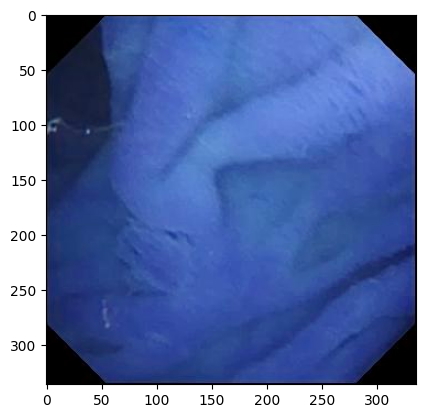

In [6]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for folder in root_dir:
      label = listdir(f"{directory_root}/{folder}")
      image_directory = listdir(f"{directory_root}/{folder}/{label[0]}")
      for image in image_directory[:300]:
        img_path = f"{directory_root}/{folder}/{label[0]}/{image}"
        image_list.append(convert_image_to_array(img_path))
        label_list.append(label[0])
    print("Done")
except Exception as e:
    print(f"Error : {e}")

In [ ]:
image_size = len(image_list)
print(image_size)

In [8]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print(np_image_list)

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

In [14]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [15]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=inputShape))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Replace 'n_classes' with the number of output classes
model.add(Dense(n_classes, activation="softmax"))


In [ ]:
model.summary()

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print("[INFO] training network...")

In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

In [ ]:
print(history.params)

In [ ]:
print(history.history.keys())

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
model.save("endoscopy.keras")

In [ ]:
print("[INFO] Calculating model accuracy")
loaded_model = load_model("endoscopy.keras")
scores = loaded_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

In [ ]:
image_location = f"/content/main_input/labelled_images/reduced_mucosal_view/Reduced mucosal view/48579eec79784294_18052.jpg"
im=convert_image_to_array(image_location)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [ ]:
result = loaded_model.predict(npp_image)
print(result)

In [ ]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])